# Exploration of Projection Spaces

In [1]:
# Feel free to add dependencies, but make sure that they are included in environment.yml

#disable some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#plots the figures in place instead of a new window
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()

from sklearn import manifold
from openTSNE import TSNE
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

## Data
To be able to explore paths in a projected space, you need to pick a problem/algorithm/model that consists of multiple states that change iteratively.

<details>
    <summary><a>Click to see an Example</a></summary>

    
An example is the solving of a Rubik's Cube. After each rotation the state of the cube changes. This results in a path from the initial state, through the individual rotations, to the solved cube.
By using projection, we can examine the individual states and paths in the two-dimensional space.
Depending on the initial state and the solution strategy the paths will differ or resemble each other.
    
This is an example of solving 10 randomly scrambled Rubik's Cubes with two different strategies, the Beginner (in green) and the Fridrich Method (in orange):
<div>
    <img alt="Rubiks's Cube Sovling Strategies" src="rubiks.png" width="600"/>
</div>
You can see that although each cube is scrambled differently in the beginning, both strategies converge to the same paths after a few steps.
You can also notice that the Beginner's method takes some additional paths that are not necessary with the Fridrich method.
</details>

### Read and Prepare Data
Read in your data from a file or create your own data.

Document any data processing steps.

In [21]:
# TODO

import os
import re
import pandas as pd

# Define board coordinates
board_size = 19
coordinates = [chr(97 + row) + chr(97 + col) for row in range(board_size) for col in range(board_size)]

# Define columns for the final DataFrame
columns = ["game_id", "move_id", "color", "winner_color", "winner_score", "result", "rules", "handicap", "starter_player", "step_count"] + coordinates

# Initialize an empty DataFrame
all_games_df = pd.DataFrame(columns=columns)

# Helper functions
def parse_metadata_and_moves(sgf_content):
    moves = []
    # Determine rules and handicap
    rules = "Unknown"
    handicap = 0

    if "RU[" in sgf_content:
        rules = sgf_content.split("RU[")[1].split("]")[0]
    if "HA[" in sgf_content:
        handicap = int(sgf_content.split("HA[")[1].split("]")[0])
    
    # Determine winner information
    winner_color = "black" if "RE[B+" in sgf_content else "white"
    result = "resign" if "Resign" in sgf_content else "score"
    winner_score = None
    if result == "score":
        winner_score = sgf_content.split("RE[")[1].split("]")[0][2:]
    
    # Extract moves
    sgf_moves = sgf_content.split(";")[2:]  # Skip the first two header parts
    move_id = 1
    for move in sgf_moves:
        color = "black" if move.startswith("B") else "white"
        pos = move[2:4]
        moves.append((move_id, color, pos))
        move_id += 1
    
    # Determine starter player based on the first move
    starter_player = moves[0][1] if moves else "unknown"  # "unknown" if there are no moves
    return moves, winner_color, winner_score, result, rules, handicap, starter_player

# Initialize board with all 0s
def initialize_board():
    return {coord: 0 for coord in coordinates}

# Apply moves and log each step for a single game
def process_game(game_id, moves, winner_color, winner_score, result, rules, handicap, starter_player):
    board_state = initialize_board()
    data = []
    step_count = len(moves)

    for move_id, color, pos in moves:
        # Update board with current move
        board_state[pos] = 2 if color == "black" else 1  # 2 for Black, 1 for White
        row_data = {
            "game_id": game_id,
            "move_id": move_id,
            "color": color,
            "winner_color": winner_color,
            "winner_score": winner_score,
            "result": result,
            "rules": rules,
            "handicap": handicap,
            "starter_player": starter_player,
            "step_count": step_count
        }
        row_data.update(board_state)
        data.append(row_data.copy())
        # Reset the stone to 0 for the next move
        board_state[pos] = 0
    return data

# Parse and process multiple SGF files in a folder
def process_sgf_folder(folder_path):
    global all_games_df
    game_files = []

    # Gather files with their game IDs
    for filename in os.listdir(folder_path):
        if filename.endswith(".sgf"):
            # Extract the game ID from the filename using regex
            match = re.match(r"(\d+)_", filename)
            if match:
                game_id = int(match.group(1))
                game_files.append((game_id, filename))

    # Sort files by game_id
    game_files.sort(key=lambda x: x[0])

    # Process each file in sorted order
    for game_id, filename in game_files:
        with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as file:
            sgf_content = file.read()
        moves, winner_color, winner_score, result, rules, handicap, starter_player = parse_metadata_and_moves(sgf_content)
        game_data = process_game(game_id, moves, winner_color, winner_score, result, rules, handicap, starter_player)
        game_df = pd.DataFrame(game_data, columns=columns)
        all_games_df = pd.concat([all_games_df, game_df], ignore_index=True)

# Specify the folder path and the player's color
folder_path = "final\SGF"  # Update with the path to your folder

# Process the SGF files
#process_sgf_folder(folder_path) # we dont have to run it again

# Save the merged DataFrame to an Excel file
output_path = "merged_games_data_sorted_final_new.xlsx"
#all_games_df.to_excel(output_path, index=False)

#print(f"Data saved to {output_path}")

"""
# Load the score table
score_table_path = "final\Scores_key.xlsx"  # Update with your score table path
score_df = pd.read_excel(score_table_path)

# Rename 'ID' column in score table to 'game_id' to match main DataFrame
score_df = score_df.rename(columns={"Id": "game_id"})

# Merge the score table with all_games_df on 'game_id'
merged_df = pd.merge(all_games_df, score_df, on="game_id", how="left")

# Save the merged DataFrame to an Excel file
output_path = "merged_games_with_scores_final_new.xlsx"
merged_df.to_excel(output_path, index=False)

"""

'\n# Load the score table\nscore_table_path = "final\\Scores_key.xlsx"  # Update with your score table path\nscore_df = pd.read_excel(score_table_path)\n\n# Rename \'ID\' column in score table to \'game_id\' to match main DataFrame\nscore_df = score_df.rename(columns={"Id": "game_id"})\n\n# Merge the score table with all_games_df on \'game_id\'\nmerged_df = pd.merge(all_games_df, score_df, on="game_id", how="left")\n\n# Save the merged DataFrame to an Excel file\noutput_path = "merged_games_with_scores_final_new.xlsx"\nmerged_df.to_excel(output_path, index=False)\n\n'

### Comments
- Did you transform, clean, or extend the data?  How/Why?

_TODO_

We downloaded GO games in .sgf files, and readed them froma  folder, collected some useful information with regex from the text, and extracted the steps from each game.
We also used another helper table, where we caculated some area and territory score, made some categories as well, for example whether the player is a beginner/ intermediate / master.

Then we merged these 2 tables into one based on the game_id-s.

## Projection
Project your data into a 2D space.
Try multiple (3+) projection methods (e.g., t-SNE, UMAP, MDS, PCA, ICA, other methods) with different settings and compare them.

Make sure that all additional dependencies are included when submitting.

In [64]:
# TODO

In [2]:
# Load dataset
data = pd.read_excel('/home/alba/Downloads/KGS Game/xai_proj_space_2024-lazy-legends/GOgame/merged_games_with_scores_final_new.xlsx')

# Selecting only the board state columns for dimensionality reduction
board_state_columns = data.loc[:, 'aa':'ss']

info_cols=[col for col in data.columns if col not in board_state_columns]

# Selecting only the board state columns for dimensionality reduction
board_state_columns = data.loc[:, 'aa':'ss']

# player_info_columns for merged_games_with_scores_final.xlsx
player_info_columns = data[info_cols]

Here You can see the meta data features that we collected.

In [3]:
player_info_columns.head()

game_id  move_id  color winner_color winner_score result     rules  \
0        1        1  white        white         Time  score  Japanese   
1        1        2  black        white         Time  score  Japanese   
2        1        3  white        white         Time  score  Japanese   
3        1        4  black        white         Time  score  Japanese   
4        1        5  white        white         Time  score  Japanese   

   handicap starter_player  step_count  ...             Date  \
0         4          white         105  ...  September, 2024   
1         4          white         105  ...  September, 2024   
2         4          white         105  ...  September, 2024   
3         4          white         105  ...  September, 2024   
4         4          white         105  ...  September, 2024   

   Our_players_colour Area score Area score of opponent Area_winner_color  \
0                   W       54.5                   56.0                 B   
1                   W       54.5                   56.0                 B   
2                   W       54.5                   56.0                 B   
3                   W       54.5                   56.0                 B   
4                   W       54.5                   56.0                 B   

   Area_result  Territory_score Territory_score_of_opponent  \
0          1,5              4.5                         3.0   
1          1,5              4.5                         3.0   
2          1,5              4.5                         3.0   
3          1,5              4.5                         3.0   
4          1,5              4.5                         3.0   

  Territory_winner_color  Territory_result  
0                      W               1,5  
1                      W               1,5  
2                      W               1,5  
3                      W               1,5  
4                      W               1,5  

[5 rows x 23 columns]

The board states at each move, the position of the stone placed on the board:

In [4]:
board_state_columns

aa  ab  ac  ad  ae  af  ag  ah  ai  aj  ...  sj  sk  sl  sm  sn  so  sp  \
0      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
9750   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
9751   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
9752   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
9753   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
9754   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      sq  sr  ss  
0      0   0   0  
1      0   0   0  
2      0   0   0  
3      0   0   0  
4      0   0   0  
...   ..  ..  ..  
9750   0   0   0  
9751   0   0   0  
9752   0   0   0  
9753   0   0   0  
9754   0   0   0  

[9755 rows x 361 columns]

## PCA

In [5]:
# Standardize the board state data
scaler = StandardScaler()
board_state_scaled = scaler.fit_transform(board_state_columns)

# Apply PCA to the board state columns
pca = PCA()
board_state_pca = pca.fit_transform(board_state_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components (Board State)')
plt.grid(True)
plt.show()

# Checking how many components explain a significant amount of variance
explained_variance = pca.explained_variance_ratio_

# Summary of PCA
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {np.cumsum(explained_variance)}")


Explained variance by each component: [0.00278106 0.00278098 0.00278027 0.00277979 0.00277972 0.00277971
 0.00277958 0.00277955 0.00277954 0.00277947 0.00277943 0.00277942
 0.00277935 0.00277931 0.00277928 0.00277927 0.00277925 0.00277924
 0.00277922 0.0027792  0.00277911 0.00277907 0.00277907 0.00277904
 0.00277901 0.002779   0.00277899 0.00277898 0.00277895 0.00277894
 0.00277892 0.00277891 0.00277888 0.00277888 0.00277887 0.00277884
 0.00277884 0.00277883 0.0027788  0.0027788  0.0027788  0.00277879
 0.00277878 0.00277877 0.00277876 0.00277874 0.00277874 0.00277874
 0.00277873 0.00277872 0.00277871 0.0027787  0.00277869 0.00277869
 0.00277864 0.00277859 0.00277856 0.00277856 0.00277854 0.00277845
 0.00277845 0.00277844 0.00277844 0.00277843 0.0027784  0.00277836
 0.00277836 0.00277836 0.00277835 0.00277832 0.00277832 0.00277832
 0.00277832 0.0027783  0.00277829 0.00277829 0.00277827 0.00277825
 0.00277822 0.00277821 0.0027782  0.00277819 0.00277817 0.00277816
 0.00277813 0.00277813 0

It doesn't make any sense to use PCA on the board states, as no feature (in this case board position) seems to be more important than the others.

<h4>PCA for the player info columns</h4>

In [6]:
# !!!! winner_score and Rank are excluded here!!!!
# feature names in merged_games_with_scores_final_new.xlsx
numerical_features = ['handicap', 'step_count', 
                      'Area score', 'Area score of opponent', 'Area_result', 'Territory_score', 
                      'Territory_score_of_opponent', 'Territory_result']
categorical_features = ['game_id', 'move_id', 'color', 
                        'winner_color', 'result', 'rules', 'starter_player', 
                        'level', 'Player', 'Our_players_colour', 'Area_winner_color', 'Territory_winner_color']

# Converting numerical features to numeric (int/float)
for feature in numerical_features:
    player_info_columns[feature] = pd.to_numeric(player_info_columns[feature], errors='coerce')

# Handling any NaN values that result from conversion
# For example, filling NaN values with the mean of the column
player_info_columns[numerical_features] = player_info_columns[numerical_features].fillna(
    player_info_columns[numerical_features].mean()
)

/tmp/ipykernel_43341/578163067.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_info_columns[feature] = pd.to_numeric(player_info_columns[feature], errors='coerce')
/tmp/ipykernel_43341/578163067.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_info_columns[numerical_features] = player_info_columns[numerical_features].fillna(


In [7]:
# Define preprocessor with dense output for OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ]
)

# Create a pipeline for PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA())
])

# Apply PCA to the player info columns
player_info_pca = pipeline.fit_transform(player_info_columns)

# Extract PCA component and explained variance
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_

# Get feature names from the preprocessor
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(onehot_feature_names)

# Analyze the PCA components to see the most important features
pca_components = pca.components_

# Print out the most important features for each principal component
print("\nMost important features for each principal component:\n")

for i, component in enumerate(pca_components[:10]):
    important_features = sorted(zip(all_feature_names, component), key=lambda x: abs(x[1]), reverse=True)
    print(f"Principal Component {i + 1}:")
    for feature, loading in important_features[:10]:  # Print top 10 features for each component
        print(f"  {feature}: {loading:.4f}")
    print()


Most important features for each principal component:

Principal Component 1:
  Territory_score_of_opponent: 0.4368
  Area score of opponent: 0.4179
  Area score: -0.4079
  Territory_result: 0.3632
  Area_result: 0.3628
  Territory_score: -0.3218
  level_1: 0.1539
  step_count: 0.1083
  level_3: -0.0993
  winner_color_black: 0.0784

Principal Component 2:
  handicap: -0.4796
  Territory_score: 0.4090
  Territory_result: 0.4058
  Area_result: 0.4036
  Area score: 0.3122
  Area score of opponent: -0.1736
  starter_player_black: 0.1335
  starter_player_white: -0.1335
  result_resign: -0.1215
  result_score: 0.1215

Principal Component 3:
  step_count: -0.6448
  Area score of opponent: -0.2564
  Area_winner_color_B: 0.2239
  Area_winner_color_W: -0.2239
  Territory_winner_color_B: 0.2060
  Territory_winner_color_W: -0.2060
  starter_player_black: -0.1937
  starter_player_white: 0.1937
  rules_Japanese: 0.1803
  Player_mangochia: -0.1795

Principal Component 4:
  handicap: -0.5985
  starte

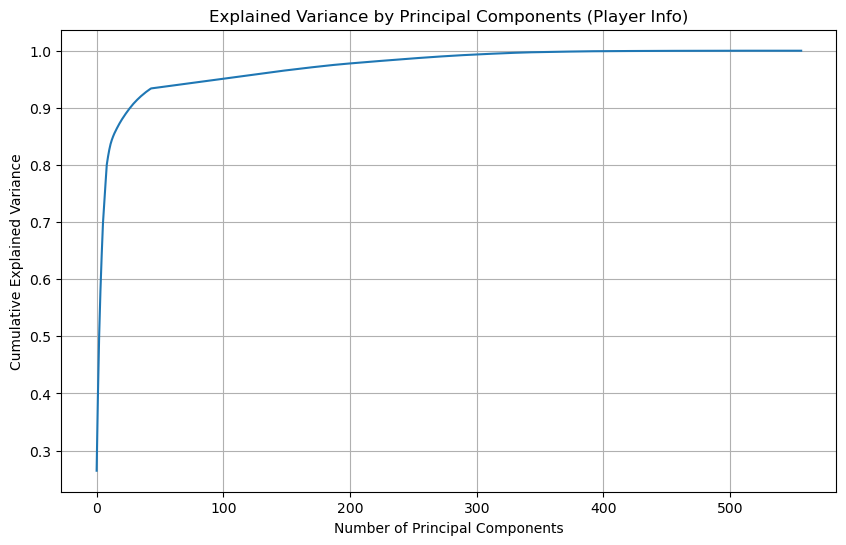

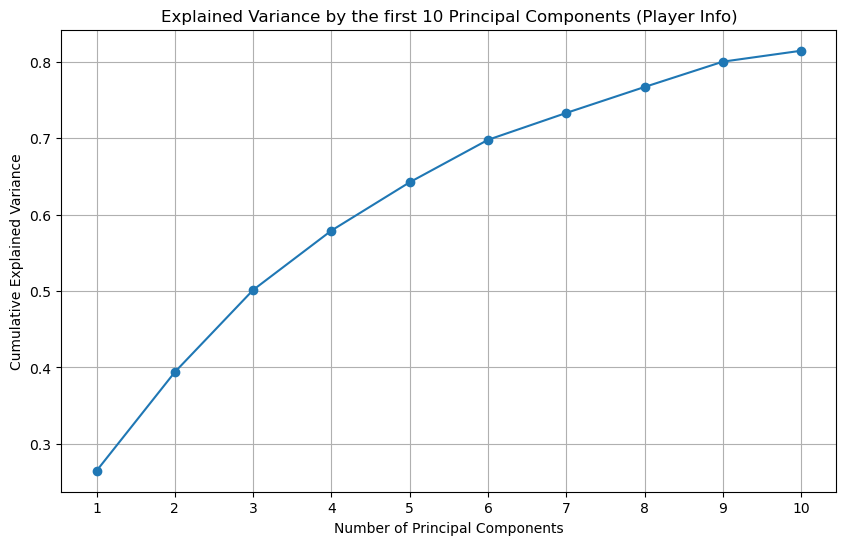

In [8]:
# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components (Player Info)')
plt.grid(True)
plt.show()

# Plot the same explained variance ratio plot as before but only displaying the first 10 principal components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance)[:10], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by the first 10 Principal Components (Player Info)')
plt.xticks(ticks=range(10), labels=range(1, 10 + 1))  
plt.grid(True)
plt.show()

<h4>PCA for every feature (both player info columns and board states)</h4>

In [9]:
all_data = pd.concat([player_info_columns, board_state_columns], axis=1)
numerical_features.extend(board_state_columns.columns)

In [10]:
all_data.head()

game_id  move_id  color winner_color winner_score result     rules  \
0        1        1  white        white         Time  score  Japanese   
1        1        2  black        white         Time  score  Japanese   
2        1        3  white        white         Time  score  Japanese   
3        1        4  black        white         Time  score  Japanese   
4        1        5  white        white         Time  score  Japanese   

   handicap starter_player  step_count  ...  sj  sk sl sm sn  so  sp sq  sr  \
0         4          white         105  ...   0   0  0  0  0   0   0  0   0   
1         4          white         105  ...   0   0  0  0  0   0   0  0   0   
2         4          white         105  ...   0   0  0  0  0   0   0  0   0   
3         4          white         105  ...   0   0  0  0  0   0   0  0   0   
4         4          white         105  ...   0   0  0  0  0   0   0  0   0   

   ss  
0   0  
1   0  
2   0  
3   0  
4   0  

[5 rows x 384 columns]

In [11]:
# Preprocessing: One-Hot Encoding for categorical features and Standardization for numerical features

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create a pipeline for PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA())
])

# Apply PCA to the player info columns
all_data_pca = pipeline.fit_transform(all_data)

# Extract PCA component and explained variance
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_

# Get feature names from the preprocessor
# Note: OneHotEncoder generates multiple columns for each category, so we need to extract all feature names
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(onehot_feature_names)

# Analyze the PCA components to see the most important features
pca_components = pca.components_

# Print out the most important features for each principal component
print("\nMost important features for each principal component:\n")
for i, component in enumerate(pca_components[:10]):
    # Get the top features for this component, sorted by the absolute value of their loadings
    important_features = sorted(zip(all_feature_names, component), key=lambda x: abs(x[1]), reverse=True)
    print(f"Principal Component {i + 1}:")
    for feature, loading in important_features[:10]:  # Print top 10 features for each component
        print(f"  {feature}: {loading:.4f}")
    print()


Most important features for each principal component:

Principal Component 1:
  Territory_score_of_opponent: 0.4352
  Area score of opponent: 0.4163
  Area score: -0.4071
  Territory_result: 0.3611
  Area_result: 0.3607
  Territory_score: -0.3214
  level_1: 0.1535
  step_count: 0.1069
  level_3: -0.0992
  winner_color_black: 0.0780

Principal Component 2:
  handicap: -0.4760
  Territory_score: 0.3995
  Territory_result: 0.3978
  Area_result: 0.3957
  Area score: 0.3050
  Area score of opponent: -0.1660
  starter_player_black: 0.1346
  starter_player_white: -0.1346
  result_resign: -0.1192
  result_score: 0.1192

Principal Component 3:
  step_count: 0.6217
  Area score of opponent: 0.2453
  Area_winner_color_B: -0.2103
  Area_winner_color_W: 0.2103
  Territory_winner_color_B: -0.1943
  Territory_winner_color_W: 0.1943
  starter_player_black: 0.1703
  starter_player_white: -0.1703
  Player_mangochia: 0.1702
  rules_Japanese: -0.1672

Principal Component 4:
  handicap: -0.5060
  starter_

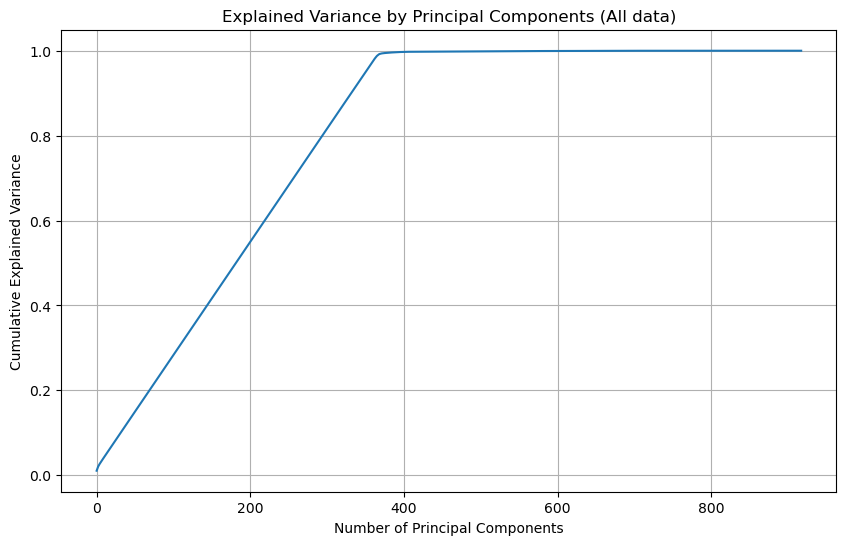

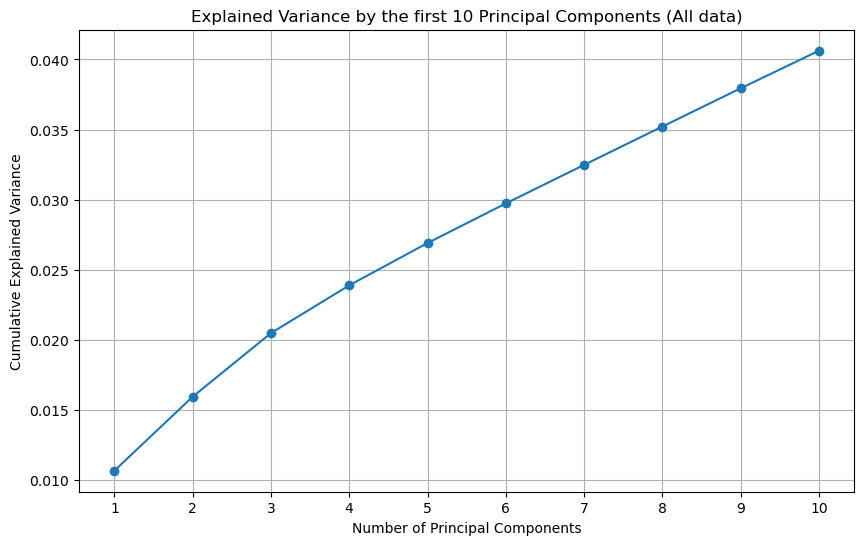

In [12]:
# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components (All data)')
plt.grid(True)
plt.show()

# Plot the same explained variance ratio plot as before but only displaying the first 10 principal components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance)[:10], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by the first 10 Principal Components (All data)')
plt.xticks(ticks=range(10), labels=range(1, 10 + 1))  
plt.grid(True)
plt.show()

<h3> Brief insights from PCA for all_data (this includes all features)</h3>

**Principal Component 1:**  It mainly deals with the differences in territory and area scores, showing how these scores influence the game's outcome and overall control of the board.

**Principal Component 2:** It focuses on the effect of game handicaps and the final scores, highlighting how initial advantages or disadvantages impact the result.

**Principal Component 3:** It is all about the number of moves and how the game's progression ties into scoring patterns, with some emphasis on the order of players and rules used.

**Principal Component 4:** It captures the role of handicaps and which player starts, showing how these aspects shape the game’s balance and scoring.

**Principal Component 5:** It looks at how certain player attributes and winning conditions influence the outcome, especially the role of player color and related strategies.

In [13]:
player_info_pca

array([[-2.56972002e-01, -1.13613815e+00,  2.21209921e+00, ...,
        -1.23202326e-15,  2.98885460e-16, -1.76560590e-17],
       [-2.57278066e-01, -1.13578791e+00,  2.20957852e+00, ...,
         1.81602177e-16, -2.05224192e-16,  9.55429946e-18],
       [-2.56972002e-01, -1.13613815e+00,  2.21209921e+00, ...,
         1.66896907e-16,  2.85589067e-16, -1.18001352e-18],
       ...,
       [ 2.90282725e+00, -2.53119759e+00,  1.88180756e+00, ...,
         9.63906110e-18, -3.57986474e-18,  3.69702945e-18],
       [ 2.90313332e+00, -2.53154785e+00,  1.88432841e+00, ...,
         4.10361198e-18,  1.75310587e-18, -2.98190384e-18],
       [ 2.90282725e+00, -2.53119759e+00,  1.88180756e+00, ...,
         4.81259742e-18, -1.42628565e-18,  1.91088259e-18]])

Length of pca_index: 9755
Length of player_info_pca: 9755
Checks begin here...
[1 2 3]
level
2    5677
1    2434
3    1644
Name: count, dtype: int64
[1 2 3]
Checks end here.


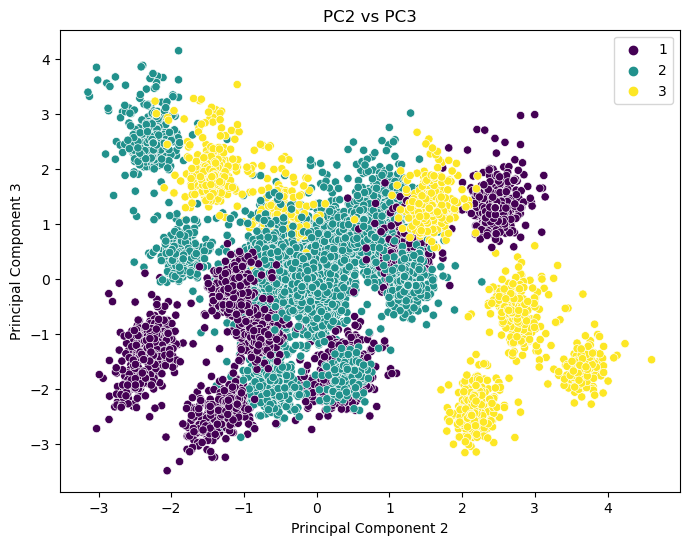

In [14]:
# pca_index corresponds to the entire index of player_info_columns
pca_index = player_info_columns.index

# Check if lengths match
print("Length of pca_index:", len(pca_index))
print("Length of player_info_pca:", len(player_info_pca))

# Create the pca_df DataFrame using the first 3 principal components
player_info_pca = pipeline.fit_transform(all_data)
pca_df = pd.DataFrame(player_info_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])

# Use pca_index to get the correct 'level' values from player_info_columns
pca_df['level'] = player_info_columns.loc[pca_index, 'level'].values

# JUST SOME CHECKS
print("Checks begin here...")
print(player_info_columns['level'].unique())
print(player_info_columns['level'].value_counts())
print(pca_df['level'].unique())
print("Checks end here.")

# Plotting PC1 vs PC2
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='level', palette='viridis')
plt.title('PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Plotting PC1 vs PC3
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC3', hue='level', palette='viridis')
plt.title('PC1 vs PC3')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.legend()
plt.show()

# Plotting PC2 vs PC3
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC2', y='PC3', hue='level', palette='viridis')
plt.title('PC2 vs PC3')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.legend()
plt.show()

# 3D Plot of PC1, PC2, and PC3
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['level'], cmap='viridis')
ax.set_title('3D Plot of PC1, PC2, and PC3')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc, label='Level')
plt.show()

First 2 PC with the level of the player (beginner, intermediate, master)

In [15]:
fig = px.scatter_3d(pca_df, x=pca_df['PC1'], y=pca_df['PC2'], z=pca_df['PC3'],
              color=pca_df['level'])
fig.show()

### Comments
- Which features did you use? Why?
- Which projection methods did you use? Why?
- Why did you choose these hyperparameters?
- Are there patterns in the global _and_ the local structure?

_TODO_

### Meta Data Encoding 
Encode addtional features in the visualization.

Use features of the source data and include them in the projection, e.g., by using color, opacity, different shapes, or line styles, etc.

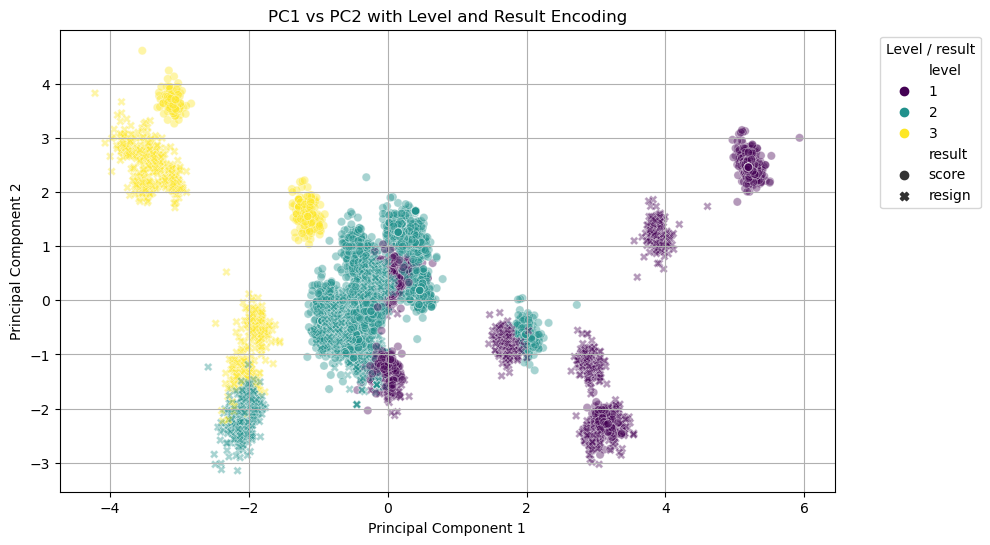

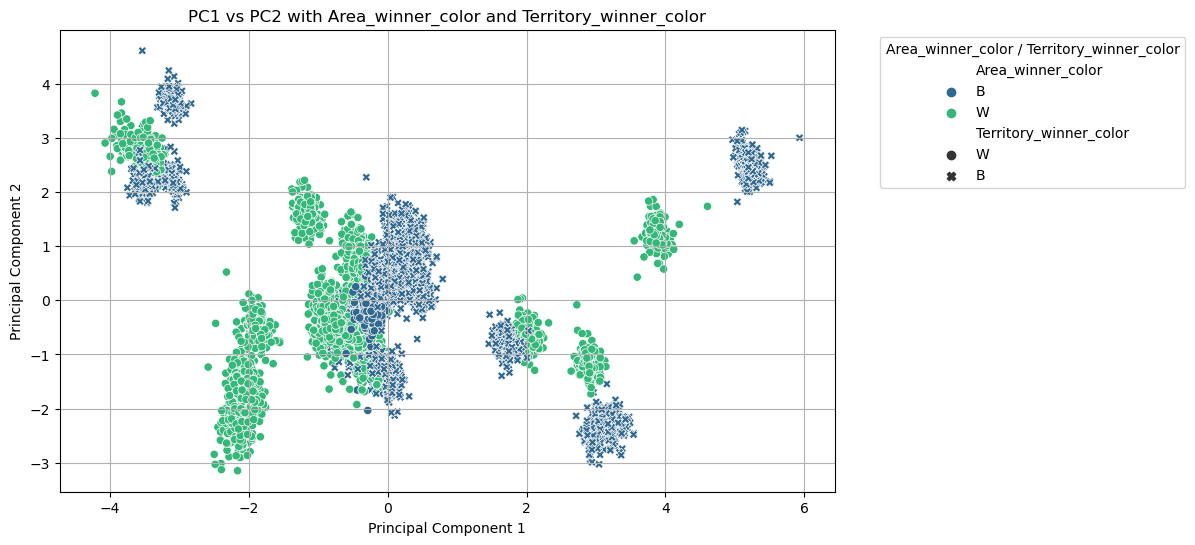

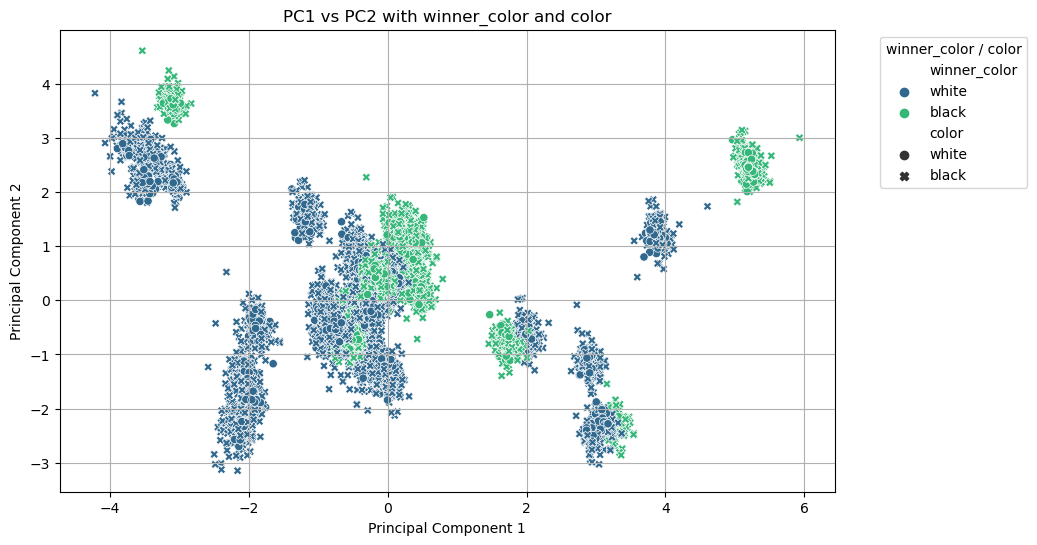

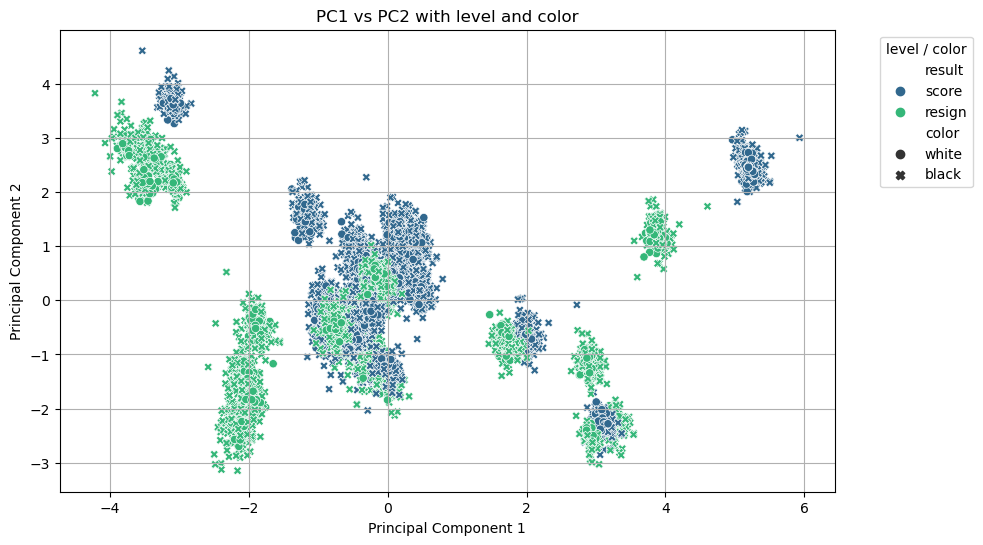

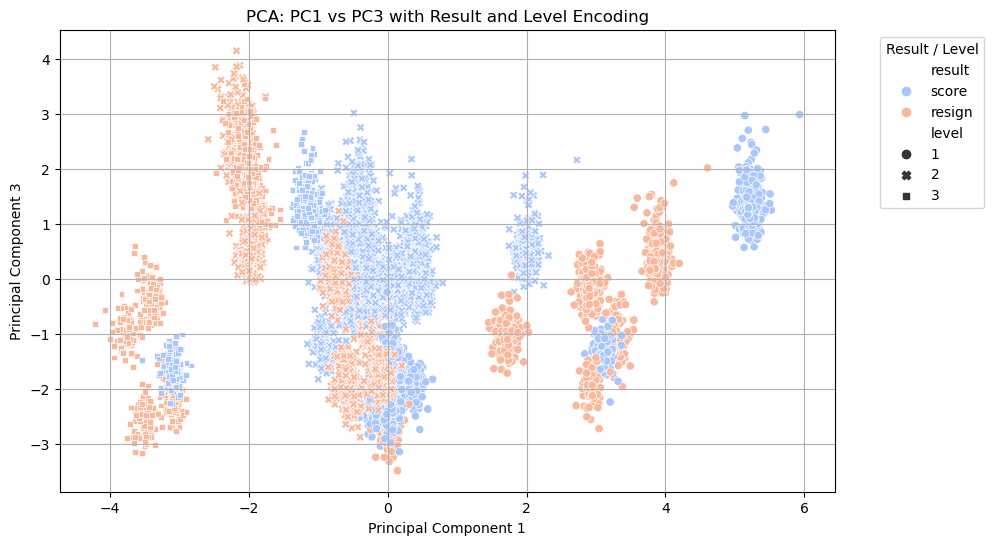

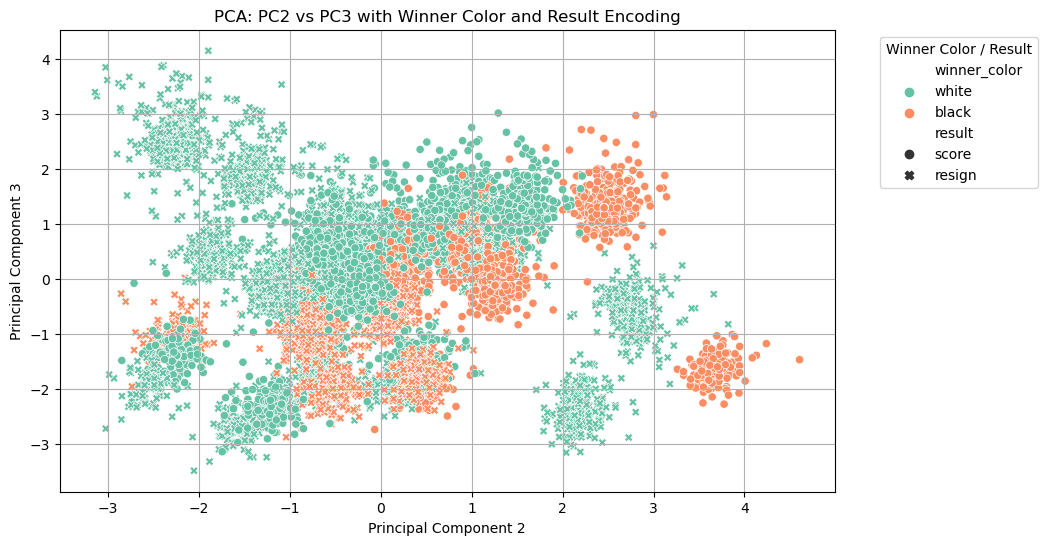

In [16]:
# 1. PCA Implementation
# ---------------------------------
"""pca = PCA(n_components=3)  # We are interested in the first 3 components
pca_components = pca.fit_transform(player_info_columns[numerical_features])

# Create a DataFrame for easy handling of PCA components
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2', 'PC3'])"""


# Optionally, add meta-data features for encoding
pca_df['level'] = player_info_columns['level'].values
pca_df['winner_color'] = player_info_columns['winner_color'].values
pca_df['result'] = player_info_columns['result'].values
pca_df['starter_player'] = player_info_columns['starter_player'].values
pca_df['Area_winner_color'] = player_info_columns['Area_winner_color'].values
pca_df['Territory_winner_color'] = player_info_columns['Territory_winner_color'].values
pca_df['color'] = player_info_columns['color'].values

# ---------------------------------
# 2. PCA Plots with Meta-Data Encoding
# ---------------------------------
# PC1 vs PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='level', style='result', palette='viridis', alpha=0.4)
plt.title('PC1 vs PC2 with Level and Result Encoding')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Level / result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Area_winner_color', style='Territory_winner_color', palette='viridis')
plt.title('PC1 vs PC2 with Area_winner_color and Territory_winner_color')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Area_winner_color / Territory_winner_color', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='winner_color', style='color', palette='viridis')
plt.title('PC1 vs PC2 with winner_color and color')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='winner_color / color', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='result', style='color', palette='viridis')
plt.title('PC1 vs PC2 with level and color')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='level / color', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# PC1 vs PC3
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC3', hue='result', style='level', palette='coolwarm')
plt.title('PCA: PC1 vs PC3 with Result and Level Encoding')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.legend(title='Result / Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# PC2 vs PC3
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC2', y='PC3', hue='winner_color', style='result', palette='Set2')
plt.title('PCA: PC2 vs PC3 with Winner Color and Result Encoding')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.legend(title='Winner Color / Result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

WHAT DO WE SEE HERE? ------------------------

In [17]:
def determine_phase(df):
    # Group by game_id
    df['phase'] = df.groupby('game_id')['move_id'].transform(
        lambda x: ["starter" if step <= 20 
                   else "final" if step > (x.max() - 20) 
                   else "intermediate"
                   for step in x]
    )
    return df

# Apply the function to the DataFrame
player_info_columns = determine_phase(player_info_columns)

/tmp/ipykernel_43341/1667704383.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
pca_df['phase'] = player_info_columns['phase'].values
pca_df['Player']=player_info_columns['Player'].values

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='winner_color', style='result', alpha=0.7, palette='viridis')
plt.title('PCA: PC1 vs PC2 with winner_color and result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='winner_color / result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Here we can see that whether the white player wins, in most cases, his opponent resign.
If black wins, in that case most of the time he wins with scores (not resign)

(Black plays first unless given a handicap of two or more stones, in which case White plays first)

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df.query('Player != "mangochia"'), x='PC1', y='PC2', hue=player_info_columns['step_count'], style='result', alpha=0.7, palette='viridis')
plt.title('PCA: PC1 vs PC2 with number of all steps and result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='winner_color / result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

We can see that the games with a lot of step, like above 350, they usually end without resigning, the players finishes the game until both of them pass that step.

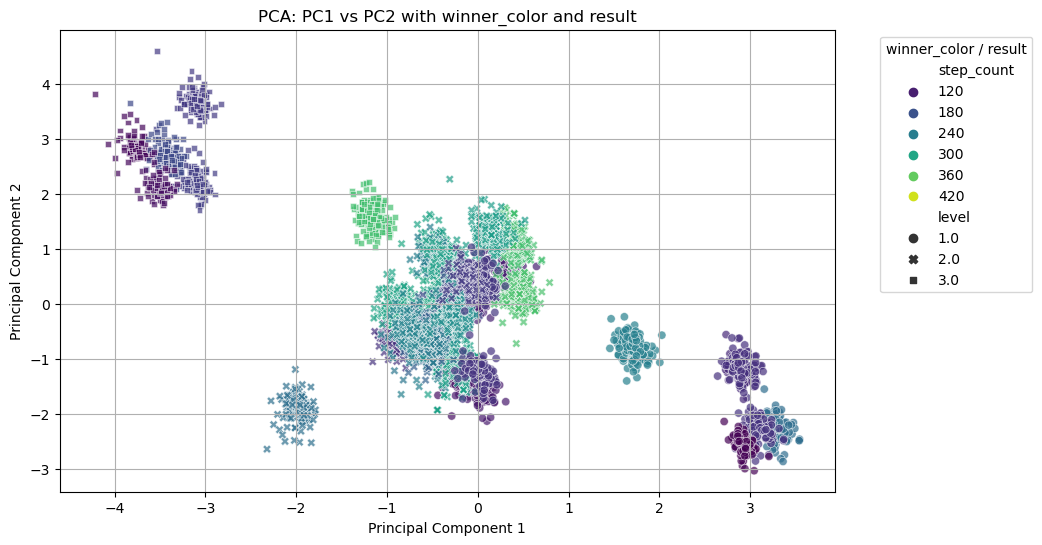

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df.query('Player != "mangochia"'), x='PC1', y='PC2', hue=player_info_columns['step_count'], style='level', alpha=0.7, palette='viridis')
plt.title('PCA: PC1 vs PC2 with winner_color and result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='winner_color / result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

We can see here that usually the master players have games with much fewer steps.

### Comments
- Which features did you use? Why?
- How are the features encoded?

_TODO_

### Link States
Connect the states that belong together.

The states of a single solution should be connected to see the path from the start to the end state.
How the points are connected is up to you, for example, with straight lines or splines.

In [22]:

# Apply PCA
pca = PCA(n_components=2)
pca_board_states = pca.fit_transform(board_state_scaled)

# Combine PCA results with game_data
game_data_pca = all_data.copy()
game_data_pca[['PC1', 'PC2']] = pca_board_states

# Determine the phase and add to `game_data_pca`
game_data_pca = determine_phase(game_data_pca)



 #Ensure move_id is numeric
game_data_pca['move_id'] = pd.to_numeric(game_data_pca['move_id'], errors='coerce')

# Filter and sort by move_id
filtered_pca_GO_1 = game_data_pca[game_data_pca['game_id'] == 31].sort_values('move_id')
filtered_pca_GO_2 = game_data_pca[game_data_pca['game_id'] == 23].sort_values('move_id')

# Visualization with lines and nodes
lines_1 = alt.Chart(filtered_pca_GO_1).mark_line(
    opacity=0.3,
    strokeWidth=1.5
).encode(
    x='PC1',
    y='PC2',
    color=alt.Color('phase:N', scale=alt.Scale(domain=['starter', 'intermediate', 'final'], range=['blue', 'green', 'red'])),
    order='move_id:Q'
)

nodes_1 = alt.Chart(filtered_pca_GO_1).mark_circle(size=30, opacity=0.6).encode(
    x='PC1',
    y='PC2',
    color=alt.Color('phase:N', scale=alt.Scale(domain=['starter', 'intermediate', 'final'], range=['blue', 'green', 'red']))
)
# Visualization with lines and nodes
lines_2 = alt.Chart(filtered_pca_GO_2).mark_line(
    opacity=0.3,
    strokeWidth=1.5
).encode(
    x='PC1',
    y='PC2',
    color=alt.Color('phase:N', scale=alt.Scale(domain=['starter', 'intermediate', 'final'], range=['blue', 'green', 'red'])),
    order='move_id:Q'
)

nodes_2 = alt.Chart(filtered_pca_GO_2).mark_circle(size=30, opacity=0.6).encode(
    x='PC1',
    y='PC2',
    color=alt.Color('phase:N', scale=alt.Scale(domain=['starter', 'intermediate', 'final'], range=['blue', 'green', 'red']))
)


# Combine lines and nodes
path_chart_with_nodes_1 = (lines_1 + nodes_1).properties(
    width=500,
    height=500,
    title="Paths of Master Player"
).interactive()
path_chart_with_nodes_2 = (lines_2 + nodes_2).properties(
    width=500,
    height=500,
    title="Paths of Begginer Player"
).interactive()

path_chart_with_nodes_1 | path_chart_with_nodes_2

alt.HConcatChart(...)

This analysis visualizes the progression of moves for a **master player** (`game_id = 31`) and a **beginner player** (`game_id = 23`) in a Go game. The data has been processed using **Principal Component Analysis (PCA)** to reduce the dimensionality of the game state data, enabling a 2D visualization of each player's moves.

- **Color Coding by Game Phase**: The moves are color-coded based on the phase of the game:
  - **Blue**: Opening phase (starter)
  - **Green**: Middle game phase (intermediate)
  - **Red**: Endgame phase (final)

- **Line and Node Visualization**: 
  - **Lines** represent the sequential progression of moves, ordered by `move_id`.
  - **Nodes** represent individual moves at each point in the sequence.

By displaying both visualizations side by side, we can compare the strategic choices and decision-making patterns of the master player versus the beginner player.


## Optional
<details>
    <summary><a>Projection Space Explorer (click to reveal)</a></summary>

    
<h2>Projection Space Explorer</h2>

The <a href="https://jku-vds-lab.at/pse/">Projection Space Explorer</a> is a web application to plot and connect two dimensional points. 
Metadata of the data points can be used to encode additonal information into the projection, e.g., by using different shapes or colors.
    
Further Information:
<ul>
    <li>Paper: <a href="https://jku-vds-lab.at/publications/2020_tiis_pathexplorer/">https://jku-vds-lab.at/publications/2020_tiis_pathexplorer/</a>
    <li>Repo: <a href="https://github.com/jku-vds-lab/projection-space-explorer/">https://github.com/jku-vds-lab/projection-space-explorer/</a>
    <li>Application Overview: <a href="https://jku-vds-lab.at/pse/">https://jku-vds-lab.at/pse/</a>
</ul>

<h3>Data Format</h3>
How to format the data can be found in the <a href="https://github.com/jku-vds-lab/projection-space-explorer/#data-format">Projection Space Explorer's README</a>.

Example data with three lines, with two colors (algo) and additional mark encoding (cp):

<table>
<thead>
  <tr>
    <th>x</th>
    <th>y</th>
    <th>line</th>
    <th>cp</th>
    <th>algo</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>0.0</td>
    <td>0</td>
    <td>0</td>
    <td>start</td>
    <td>1</td>
  </tr>
  <tr>
    <td>2.0</td>
    <td>1</td>
    <td>0</td>
    <td>state</td>
    <td>1</td>
  </tr>
  <tr>
    <td>4.0</td>
    <td>4</td>
    <td>0</td>
    <td>state</td>
    <td>1</td>
  </tr>
  <tr>
    <td>6.0</td>
    <td>1</td>
    <td>0</td>
    <td>state</td>
    <td>1</td>
  </tr>
  <tr>
    <td>8.0</td>
    <td>0</td>
    <td>0</td>
    <td>state</td>
    <td>1</td>
  </tr>
  <tr>
    <td>12.0</td>
    <td>0</td>
    <td>0</td>
    <td>end</td>
    <td>1</td>
  </tr>
  <tr>
    <td>-1.0</td>
    <td>10</td>
    <td>1</td>
    <td>start</td>
    <td>2</td>
  </tr>
  <tr>
    <td>0.5</td>
    <td>5</td>
    <td>1</td>
    <td>state</td>
    <td>2</td>
  </tr>
  <tr>
    <td>2.0</td>
    <td>3</td>
    <td>1</td>
    <td>state</td>
    <td>2</td>
  </tr>
  <tr>
    <td>3.5</td>
    <td>0</td>
    <td>1</td>
    <td>state</td>
    <td>2</td>
  </tr>
  <tr>
    <td>5.0</td>
    <td>3</td>
    <td>1</td>
    <td>state</td>
    <td>2</td>
  </tr>
  <tr>
    <td>6.5</td>
    <td>5</td>
    <td>1</td>
    <td>state</td>
    <td>2</td>
  </tr>
  <tr>
    <td>8.0</td>
    <td>10</td>
    <td>1</td>
    <td>end</td>
    <td>2</td>
  </tr>
  <tr>
    <td>3.0</td>
    <td>6</td>
    <td>2</td>
    <td>start</td>
    <td>2</td>
  </tr>
  <tr>
    <td>2.0</td>
    <td>7</td>
    <td>2</td>
    <td>end</td>
    <td>2</td>
  </tr>
</tbody>
</table>



Save the dataset to CSV, e.g. using pandas: <tt>df.to_csv('data_path_explorer.csv', encoding='utf-8', index=False)</tt>  
    and upload it in the Projection Space Explorer by clicking on `OPEN FILE` in the top left corner.
    
ℹ You can also include your high dimensionmal data and use it to adapt the visualization.
    
</details>


## Results
You may add additional screenshots of the Projection Space Explorer.

In [87]:
# TODO

### Interpretion
- What can be seen in the projection(s)?
- Was it what you expected? If not what did you expect?
- Can you confirm prior hypotheses from the projection?
- Did you get any unexpected insights?

_TODO_

## Submission
When you’ve finished working on this assignment please download this notebook as HTML and add it to your repository in addition to the notebook file.